In [1]:
import csv
import codecs
import urllib
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from SIRX import SIRXConfirmedModel

In [14]:
data = {}
dates = []

data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
   
datafile = urllib.request.urlopen(data_url)

reader = csv.reader(codecs.iterdecode(datafile, 'utf-8'))

first_row = next(reader)

dates = [ datetime.strptime(d, '%m/%d/%y').date() for d in first_row[4:] ]

for row in reader:
    country = row[1]
        
    if country in data:
        data[country] = [ d + int(e) for d,e in zip(data[country],row[4:]) ]
    else:
        data[country] = [ int(e) for e in row[4:] ]
        
    #print(country)

In [15]:
model = SIRXConfirmedModel()

In [24]:
population = {  
                'Netherlands' : 17180000, 
                'Italy' :       60480000,
                'Germany' :     82790000,
                'Spain' :       46660000,
                'United Kingdom' : 66440000,
                'France' : 66990000,
                'Korea, South' : 51470000,
                'Iran' : 81160000,
                'Portugal' :     10290000,
                'Greece' : 10740000,
                'Norway' : 5368000,
                'Switzerland' : 8570000,
                'Sweden' : 10120000,
                'Austria' : 8822000,
                'Belgium' : 11400000,
                'Poland' : 37980000,
                'US' : 327200000,
                'Denmark' : 5603000,
                #'Thailand' : 69040000,
             }

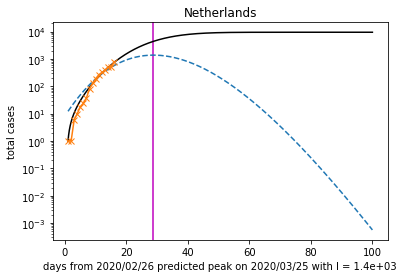

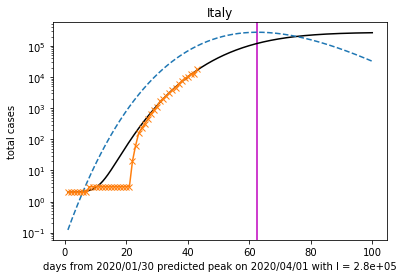

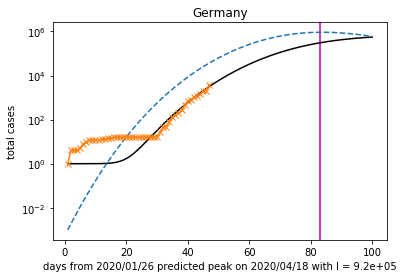

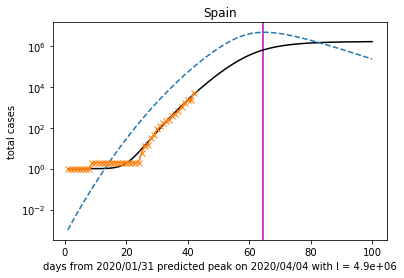

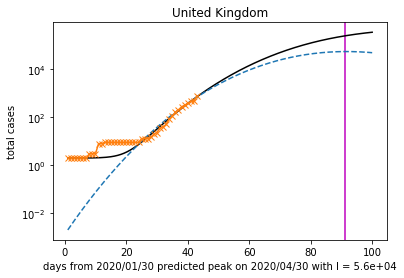

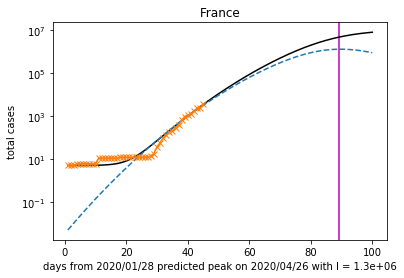

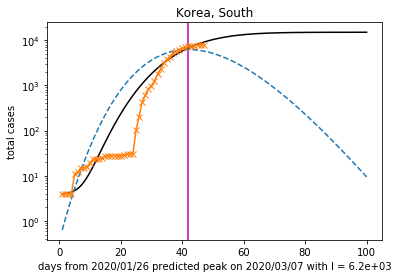

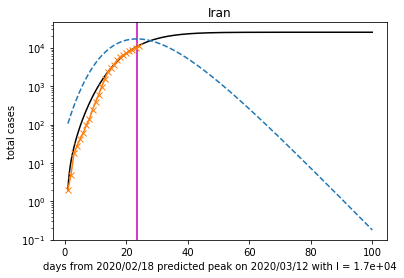

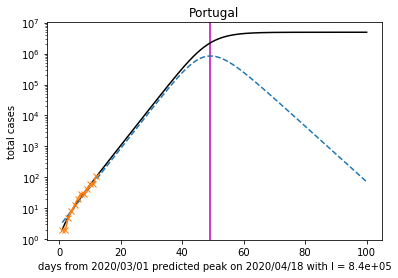

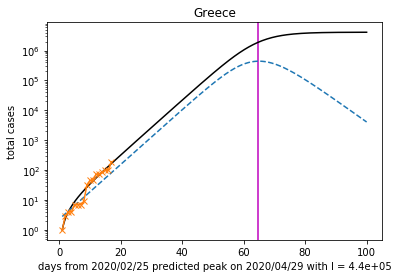

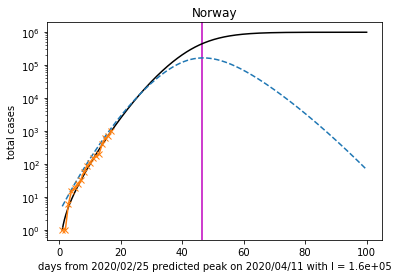

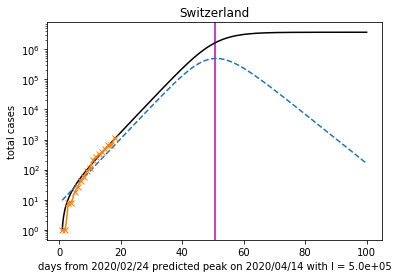

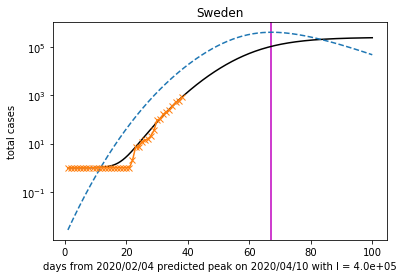

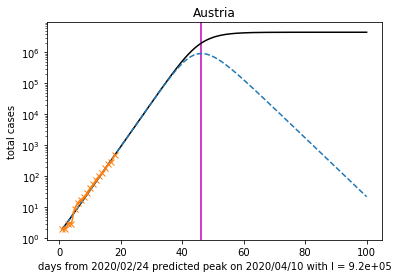

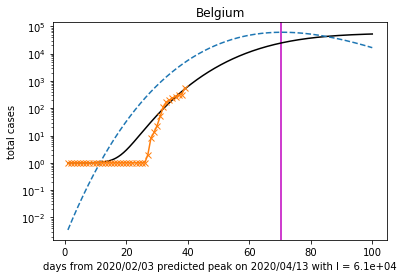

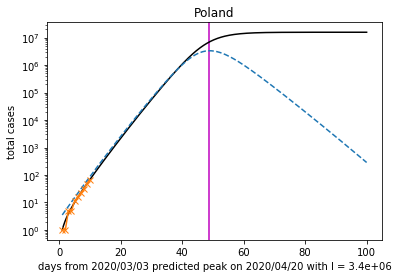

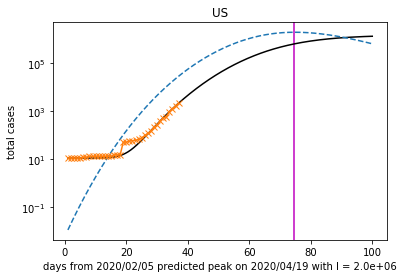

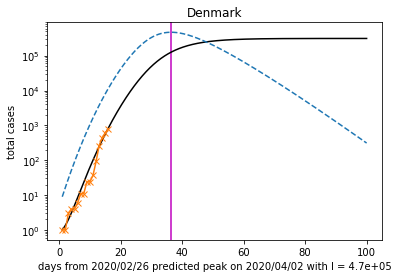

In [27]:
for country, pop in population.items():
    #print(country)
    #print("Population size", pop)

    t0 = next( i for i,d in enumerate( data[country] ) if d > 0 )
    
    if country == 'France':
        t0 += 5
        # atypical start of the pandemic in France
        
    if country == 'Korea, South':
        t0 += 5
        # atypical start of the pandemic in South Korea
        
    if country == 'Sweden':
        t0 += 5
        # atypical start of the pandemic in Sweden
        
    if country == 'US':
        t0 += 15
        
    cases = data[country][t0:]
    pop = population[country]
    
        
    #print("start on ", dates[t0])
    t = [ (d - dates[t0-1]).total_seconds() / 24 / 3600 for d in dates[t0:] ]

    out = model.fit(t,cases,maxfev=1000,N=pop)
    params = out.params
    
    #print(params)
    
    #print(cases)
    
    N = params['N']
    tt = np.logspace(np.log(t[0]), np.log(100), 1000,base=np.exp(1))

    result = model.SIRX(tt, cases[0], 
                        params['eta'],
                        params['rho'],
                        params['kappa'],
                        params['kappa0'],
                        N,
                        params['I0_factor'],
                        )
    X = result[2,:]*N
    I = result[1,:]*N
    
    imax = np.where(I == np.amax(I))[0]
    tmax = np.exp(imax/1000*np.log(100))[0]
    max_date = dates[t0-1] + timedelta(days=tmax)
    
    csfont = {}
    
    plt.axes(yscale='log')
    plt.xlabel('days from ' + dates[t0-1].strftime("%Y/%m/%d") \
               + " predicted peak on " \
               + max_date.strftime("%Y/%m/%d") \
               + " with I = %.1e" % float(np.amax(I)),**csfont)
               
    plt.ylabel('total cases',**csfont)
    plt.axvline(x=tmax,c='m')
    
    textstr = '\n'.join((
    r'predicted peak on %s' % (max_date.strftime("%Y/%m/%d"), ),
    r'with I = %.1e' % (float(np.amax(I)), )))
    
    plt.title(country,**csfont)
    
    plt.plot(tt, X,'-',c='k')
    plt.plot(tt, I,'--',lw=1.5)
    plt.plot(t, cases,marker='x')
    
    plt.show()
    
    #print('*'*50)
